# LIBRARIES & PACKAGES

In [1]:
import pandas as pd
import os
import numpy as np
import re


import matplotlib.pyplot as plt

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.utils import plot_model


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy.signal import find_peaks, spectrogram, stft
from scipy.fft import rfft, rfftfreq


from librosa import zero_crossings
from librosa.display import specshow
from librosa import amplitude_to_db
from xgboost import XGBClassifier

import pickle
import warnings
warnings.filterwarnings("ignore")

ABS_PATH = r"C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM"
SAVE_DIR = os.path.join(ABS_PATH, "eeg_test")


# FUNCTIONS

## Handcrafted features to be extracted

* The following is the set of features which are taken into account to build the handcrafted part of the general descriptor.<br>
Specifically, temporal domain and frequency domain features are reported in the code cell.<br>
* The last function, namely `handcr_feat_descriptor`, calls the others to aggregated the results into a list of values 

In [19]:
# Temporal domain features
def peaks_properties(signal_raw):
    peaks, _ = find_peaks(signal_raw)
    num_peaks = np.float64(len(peaks))
    p2p_amplitude = np.ptp(signal_raw)*1.0
    
    return num_peaks, p2p_amplitude

def energy(signal_raw):
    e = np.sum(signal_raw**2)*1.0
    return e

def power(signal_raw):
    pow_ = np.mean(signal_raw**2)*1.0
    return pow_

def zcr(signal_raw):
    zcr_mask = zero_crossings(np.asarray(signal_raw) * 1.0, pad=False)
    zcr_sum = np.sum(zcr_mask)*1.0
    return zcr_sum

def mean_val(signal_raw):
    return np.mean(signal_raw)*1.0

def std_val(signal_raw):
    return np.std(signal_raw)*1.0


# Frequency domain features
def dominant_freq(signal_raw, sampling_rate=173.61):

    fft_result = rfft(signal_raw)
    frequencies = rfftfreq(len(signal_raw), d=1/sampling_rate)
    amplitudes = np.abs(fft_result)
    idx_max = np.argmax(amplitudes)
    dom_freq = frequencies[idx_max]

    return dom_freq, fft_result, frequencies

def signal_magnitude_from_stft(signal_raw, flat=False, filt=False, fs=173.61, nperseg=512, noverlap=64):
    f, t, Zxx = stft(signal_raw, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spec = np.abs(Zxx)
    if filt:
        idx = np.where(f <= 20)[0]
        spec= spec[idx, :]
        # print(spec.shape)
        f = f[idx]
        # t = t[idx]
    if flat:
        return spec.flatten()
    return f,t, spec

# Aggregating function in order to build a descriptor with each single feat extracted value
def handcr_feat_descriptor(signal_raw):
    num_peaks, p2p_amplitude  = peaks_properties(signal_raw)
    e = energy(signal_raw)
    pow_ = power(signal_raw)  
    zcr_ = zcr(signal_raw)
    mean_val_ = mean_val(signal_raw)
    std_val_ = std_val(signal_raw)
    dom_freq_,_,_ = dominant_freq(signal_raw)
    spec_ = signal_magnitude_from_stft(signal_raw, flat=True, filt=True)
    
    return [num_peaks, p2p_amplitude, 
            e, pow_, zcr_, mean_val_, 
            std_val_, dom_freq_, *spec_]


## Model definition

### Descriptor builder

Key points are as follows:
* both the train and test handcrafted feature descriptors are passed, along with the corresponding instances of the original data (which will be processed in neural feature extraction).
* the neural feature extractor is set up: the architecture includes 2 LSTM layers with a dropout regularizer, followed by a FC layer 64 values long.
* the concatenated layer merges the two descriptors into a single array of values. The function returns separate descriptors for the train and test data.

In [3]:
def concat_lstm_handcr_feat_descriptor(X_train_lstm, X_test_lstm, X_train_handcrafted, X_test_handcrafted):
    
    
    inputs_lstm = Input(shape=(X_train_lstm.shape[1], 1)) # neural feat extractor init

    x_lstm = LSTM(64, return_sequences=True, recurrent_dropout=0.2)(inputs_lstm) # 1st lstm layer
    x_lstm = Dropout(0.2)(x_lstm)

    x_lstm = LSTM(32, return_sequences=False, recurrent_dropout=0.2)(x_lstm) # 2nd lstm layer
    x_lstm = Dense(64, activation='relu')(x_lstm) # FC after flattening
    x_lstm = Dropout(0.5)(x_lstm)  

    inputs_handcrafted = Input(shape=(X_train_handcrafted.shape[1],)) # handcrafted feat descriptor input init
    concatenated = Concatenate()([x_lstm, inputs_handcrafted]) # concatenation object init: both neural feat extractor and
                                                               # handcrafted feat descriptor are passed as param

    feature_extractor_model = Model(inputs=[inputs_lstm, inputs_handcrafted], # model definition
                                    outputs=concatenated)
    feature_extractor_model.summary()  # printing the extractor architecture

    # reshaping LSTM input to match required structure (batch,4097,1)
    X_train_lstm_reshaped = X_train_lstm.values.reshape((X_train_lstm.shape[0],
                                                         X_train_lstm.shape[1], 
                                                         1))


    # concat handcrafted and neural features descriptor
    concat_feat_train = feature_extractor_model.predict([X_train_lstm_reshaped, 
                                                        X_train_handcrafted])

    # same on test
    X_test_lstm_reshaped = X_test_lstm.values.reshape((X_test_lstm.shape[0], 
                                                       X_test_lstm.shape[1],
                                                       1))
    
    
    concat_feat_test = feature_extractor_model.predict([X_test_lstm_reshaped, 
                                                        X_test_handcrafted])


    return concat_feat_train, concat_feat_test # returning both concatenated train and test descriptors 

## XGB model loader

This function allows to load saved model that has been trained previously

In [4]:
def load_mod(path: str):
    xgb_model = None
    xgb_model = XGBClassifier()
    xgb_model.load_model(path)
    return xgb_model

### Classifier

This function is thought to set a custom xgb model architecture allowing users to chose the values of model parameters-of-interest.<br>
If `best_params_pkl_path` is set, a .pkl with saved parameters will be load.<br>
The function returns both the model and predictions on test data

In [5]:
def xgb_classifier(X_train, X_test, y_train, lr = None, best_params_pkl_path = None, cols_bt = None, gamma_= None,
                   max_d = None, est = None, reg_a = None, reg_l = None, subs = None):

    
    xgb_model = None
    
    default_params = {
        'objective': 'multi:softmax', 
        'num_class': 5, 
        'use_label_encoder': False, 
        'eval_metric': 'mlogloss'
    }
    
    if isinstance(best_params_pkl_path, str):  # paramters file path
        
        try:
            with open(best_params_pkl_path, 'rb') as f:
                best_params = pickle.load(f)
                print("Best parameters loaded from file.")
                xgb_model = XGBClassifier(**best_params.best_params_, **default_params)
        except FileNotFoundError:
                print(f"File '{best_params_pkl_path}' not found. Proceeding with default parameters.")
                xgb_model = XGBClassifier(learning_rate = 0.001, **default_params)
                
    elif best_params_pkl_path is None:
            xgb_model = XGBClassifier(**default_params,learning_rate =lr, colsample_bytree=cols_bt,
                                      gamma=gamma_, max_depth=max_d, n_estimator=est, reg_alpha=reg_a,
                                      reg_lambda=reg_l, subsample=subs)
        
        
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict(X_test)
    
    return xgb_model, pred

### Model evaluation

This function aims to plot the confusion matrix of predictions made by a specific model, passing true and predicted labels.<br>
The accuracy score is also printed

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    
    print("---"*10)
    print("accuracy score: ", round(accuracy_score(y_true, y_pred),2)) # printing the accuracy
    print("---"*10)

    cm = confusion_matrix(y_true, y_pred) # building the confusion matrix

    # Display settings
    y_true_labels = np.unique(y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true_labels)
    disp.plot(cmap='Blues', values_format='d')

    # Graph settings
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('Ground truth')
    plt.show()

### Model tuning

This function serves to set a search method for hyperparameter tuning:
* search method between **grid** and **random** could be chosen
* **early stopping** is set to a maximum of 5 rounds: it is preferable if `grid=True`
* `parameter grid` from which values are used either for grid and random search is thought to be fixed.<br>

The function returns the `search` oject

In [7]:
def search_for_tuning(X_train, y_train, grid=False, rand=False, early_st=False):
    search = None
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size=0.2, 
                                                            random_state=42)
    # Model config
    if early_st:
        xgb_model = XGBClassifier(
            objective='multi:softmax',
            num_class=5,
            use_label_encoder=False,
            eval_metric='mlogloss',
            early_stopping_rounds=5
        )
        # Preparazione degli eval set per early stopping
        eval_set = [(X_val, y_val)]
        fit_params = {
            "eval_set": eval_set,
            "verbose": False
        }
    else:
        xgb_model = XGBClassifier(
            objective='multi:softmax',
            num_class=5,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        fit_params = {}

    # Grid definition
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.001, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
    
    if grid:
        search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            verbose=2,
            n_jobs=-1
        )
        search.fit(X_train_sub, y_train_sub, **fit_params)
    
    elif rand:
        search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_grid,
            n_iter=50,
            scoring='accuracy',
            cv=10,
            verbose=2,
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_train_sub, y_train_sub, **fit_params)
            
    print("Best Parameters:", search.best_params_)
    print("Best Score:", search.best_score_)
    
    return search

## Data loader & processing

The keypoints are the following:
* orignal set of data arrenged as `pd.DataFrame` is passed
* column with class labels is dropped and saved into a specific var
* handcrafted features descriptor is extracted from each row of the dataframe
* train/test splitting is performed with 90% vs 10% proportion
* the corresponding instances of the handcrafted feature descriptor are saved in order to been processed for neural features extraction and concatenation
* if `normalize=True`, a scaling procedure is performed over train data and used for normalizing test
* label encore step is addressed to fit with xgb model requirements for prediction making<br>

The function returns handcrafted feature descriptors either for train and test data, the train and test class labels and corresponding instances of the original data (both for train and test) to further neural extraction

In [8]:
def data_loader(signals: pd.DataFrame, normalize=False):
      
    X = signals.drop(columns=['class']) # dividing signals from classes
    y = signals['class']                # by saving EEG tracings into 'X' variable and
                                    # classes into 'y' variable

    X_handcr_descriptor = X.apply(lambda row: handcr_feat_descriptor(row), axis=1, result_type='expand')
    
    X_train, X_test, y_train, y_test = train_test_split(X_handcr_descriptor, y, test_size=0.1, random_state=42) # train/test splitting
    X_train_lstm = X.iloc[X_train.index]
    X_test_lstm = X.iloc[X_test.index]

    if normalize:
        scaler = StandardScaler() # instantiating 'scaler' object
        scaler.set_output(transform="pandas") # keep a pd.DataFrame as output data structure
        X_train = scaler.fit_transform(X_train, )
        # joblib.dump(scaler, 'scaler.pkl')# scaling data by mean and dividing over std
        X_test = scaler.transform(X_test) # scaling data of the validation set using train set parameters
        
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)  # Converting ['A','B','C','D','E'] labels in [0,1,2,3,4]
    y_test = le.transform(y_test)

    return X_train, X_test, y_train, y_test, X_train_lstm, X_test_lstm


# MAIN

## Data reading & loading

In [9]:
file_path = os.path.join(ABS_PATH, "eeg.csv") # path setting 
eeg = pd.read_csv(file_path, sep=";") # reading the data

In [10]:
# loading the data
X_train, X_test, y_train, y_test, X_train_lstm, X_test_lstm = data_loader(eeg, normalize=True)

In [11]:
# Extracting features and descriptor building
extracted_features_train, extracted_features_test = concat_lstm_handcr_feat_descriptor(
                                                            X_train_lstm=X_train_lstm,
                                                            X_test_lstm=X_test_lstm,
                                                            X_train_handcrafted=X_train,
                                                            X_test_handcrafted=X_test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4097, 1)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 4097, 64)     16896       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4097, 64)     0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           12416       ['dropout[0][0]']                
                                                                                              

# MODEL RUNNING

The following model has been built using a pretrained parameters choice whose tuning was conducted by considering a simpler model with handcrafted features descriptor only

In [12]:
bp_path = r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl'
mod_1a, prdct = xgb_classifier(X_train=extracted_features_train,
                       X_test=extracted_features_test,
                       y_train=y_train,
                       best_params_pkl_path=bp_path)

Best parameters loaded from file.


              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       0.75      1.00      0.86         3
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00        13

    accuracy                           0.94        50
   macro avg       0.91      0.96      0.92        50
weighted avg       0.95      0.94      0.94        50

------------------------------
accuracy score:  0.94
------------------------------


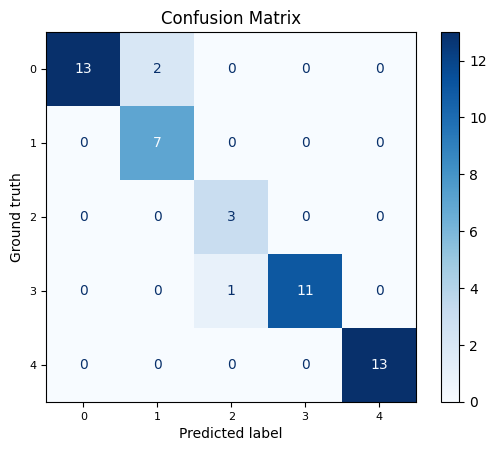

In [13]:
print(classification_report(y_test, prdct))
plot_confusion_matrix(y_true=y_test, y_pred=prdct)

As we can see, by applying this parameters selection seems to be enough for leading to high performance.<br>

Let now observe

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       0.75      1.00      0.86         3
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00        13

    accuracy                           0.94        50
   macro avg       0.91      0.96      0.92        50
weighted avg       0.95      0.94      0.94        50

------------------------------
accuracy score:  0.94
------------------------------


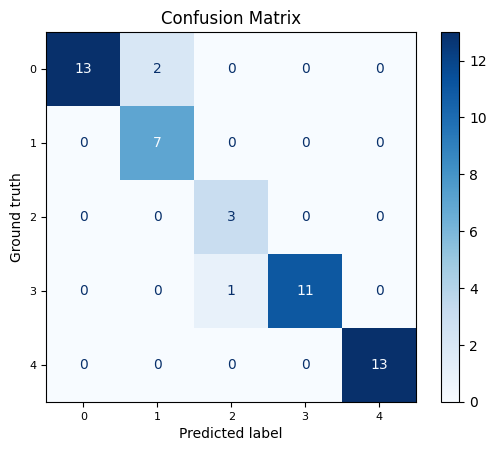

In [14]:
# mod.save_model('best_model_94.model')
mod_1b = load_mod(r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\src\best_model_94.model')
predictions = mod_1b.predict(extracted_features_test)
print(classification_report(y_test, predictions))
plot_confusion_matrix(y_true=y_test, y_pred=predictions)

## Considerations

* if varying the value of freq filter, it could be noticed that:
    * at a low level (i.e. 5 or 10), the performance is worst -> 0.8
    * at a high level, such as the whole flatten spectrogram, the performance does not increase than that obtained with freq_limit = 20 -> 0.86<br>

* the actual information gain seems to be provided by spectrogram component, since an accuracy score of 0.68 is obtain is they are excluded from the set of features. On the other hand, if neural feature are dropped, the accuracy score is 0.8, demonstrating that they lead to a pretty little short improvement on training

* VERY IMPORTANT: after playing around on changing 'nperseg' and 'overlap' params of stft, the best extraction results of making larger Frequency feats extraction (by increasing the rate of 'nperseg') and shortening di overlapping rate so that i avoid the analysis on time -> accuracy = 0.94


## HANDCRAFTED FEATURES ONLY

In [ ]:
bp_hc_only_bp_path = r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl'
pred_handcr_only = xgb_classifier(X_train=X_train,
                       X_test=X_test,
                       y_train=y_train,
                       best_params_pkl_path=bp_hc_only_bp_path)

Best parameters loaded from file.


------------------------------
accuracy score:  0.9
------------------------------


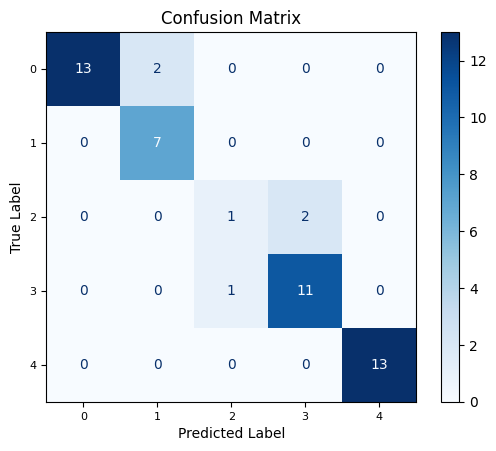

In [ ]:
plot_confusion_matrix(y_test, pred_handcr_only)

## TUNING

### Search

In [ ]:
search_result = search_for_tuning(X_train=extracted_features_train, 
                                  y_train=y_train,
                                  grid=True,
                                  early_st=True)

### Write the best params

In [ ]:
# with open('rs_2_lay_lstm_xgn.pkl', 'wb') as f:
#     pickle.dump(random_search, f)

### Load the best params

In [ ]:
# with open(r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\hyperparam tuning\gs_xgb.pkl', 'rb') as f:
#     gs_loaded = pickle.load(f)
# print(gs_loaded.best_params_)

## PLOT FOR PRESENTATION

The follwing cells are set for graphics building, in order to add them on presentation.<br>
Namely, plot for **stft** and **fft** are made

#### Plot spectr with STFT

(59, 11)


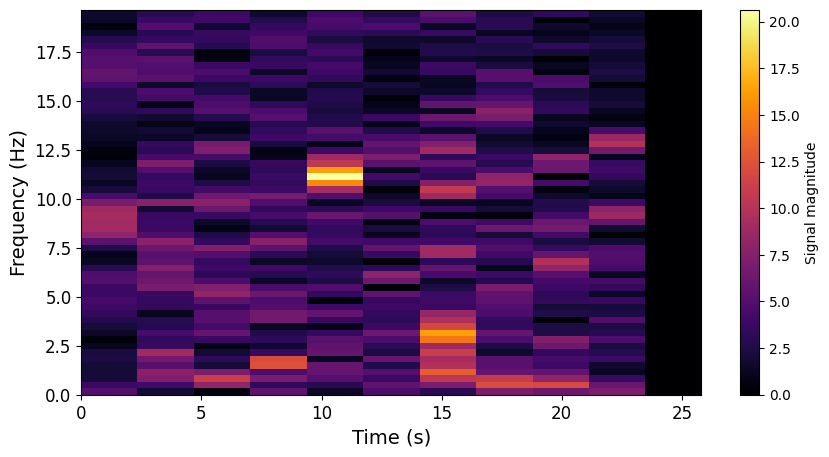

In [21]:
eeg_no_cl = eeg.drop(columns=['class'])
spec_freqs, spec_times,spec = signal_magnitude_from_stft(eeg_no_cl.iloc[1], filt=True, flat=False)
print(spec.shape)

# plot definition
plt.figure(figsize=(10, 5))
plt.imshow(spec, 
           extent=[spec_times[0], spec_times[-1], spec_freqs[0], spec_freqs[-1]],  # Usa spec.shape per dimensioni
           origin='lower', aspect='auto', interpolation='nearest', cmap='inferno')

plt.colorbar(label="Signal magnitude")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.title("Spectrogram from STFT")
plt.show()

#### Plot FFT

5 indices are randomly chosen to plot the corresponding FFT graph, allowing users to check how the signal amplitude is unequally distributed along low and high frequencies

In [15]:
np.random.seed(42)
random_idx = [np.random.randint(0, 500) for _ in range(5)]
print(random_idx)

[102, 435, 348, 270, 106]


In [16]:
_,fft_0, freqs_0 = dominant_freq(eeg_no_cl.iloc[random_idx[0]])
_,fft_1, freqs_1 = dominant_freq(eeg_no_cl.iloc[random_idx[1]])
_,fft_2, freqs_2 = dominant_freq(eeg_no_cl.iloc[random_idx[2]])

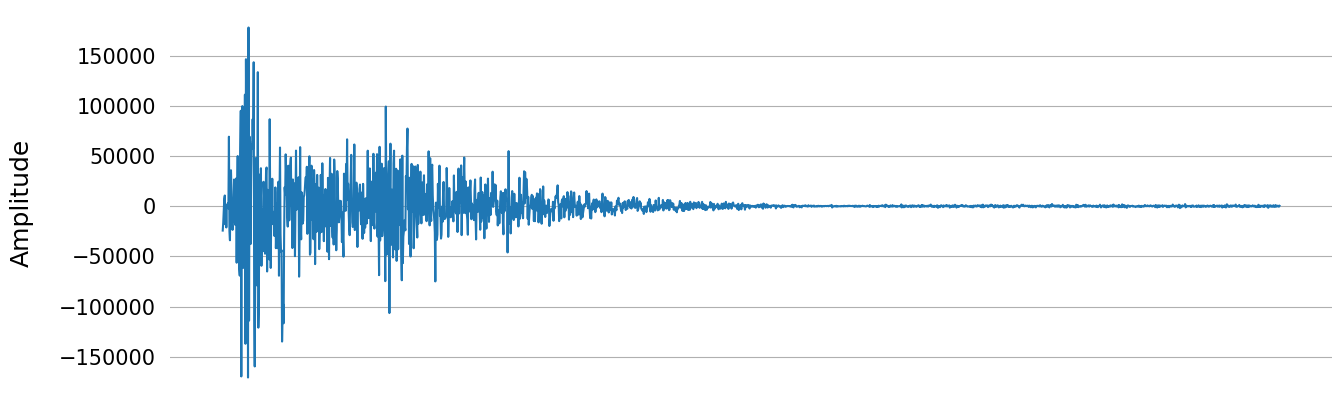

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(freqs_1, fft_1)

plt.ylabel('Amplitude', fontsize=18, labelpad=18)
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)


for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(True, axis='y')

plt.xticks([])
plt.yticks(fontsize=15)
ax = plt.gca()

ax.tick_params(axis='x', pad=15)  
ax.tick_params(axis='y', pad=10)

plt.show()

## BUILDING OTHER EEG SIGNALS .CSV

In [67]:
import mne
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

In [68]:
def get_last_file_number(directory):
    files = [f for f in os.listdir(directory) if re.match(r"eeg_\d+\.csv", f)]
    numbers = [int(re.search(r"eeg_(\d+)\.csv", f).group(1)) for f in files]
    return max(numbers) if numbers else 100 

In [69]:
def chb_read_and_process(edf_path, start: int):
    sign = mne.io.read_raw_edf(edf_path, preload=True)
    sign.plot()
    sign.filter(l_freq=0.53, h_freq=40.0, fir_design='firwin')  # Band pass filter

    start_sample = int(sign.time_as_index(start))  
    sign_sample = sign.get_data(start=start_sample)  
    # n_ch = min(n_ch, sign.shape[0])  
    
    sig_filt = sign_sample[:sign.info['nchan'], :4097]  
    sig_df = pd.DataFrame(sig_filt)
    sig_df_adapt = (sig_df * 1e7).round().astype(int)  
    
    return sig_df_adapt 

In [70]:
def save_rows_to_csv(df, dir_path:str, base_filename="eeg"): 
    last_eeg_index = get_last_file_number(dir_path)
    for i, row in df.iterrows():
        if not (row == 0).all():
            row = row.to_frame().T
            row.to_csv(os.path.join(dir_path, f"{base_filename}_{i+last_eeg_index}.csv"), sep=";", index=False, header=False)

Extracting EDF parameters from C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\dibmir\AppData\Local\Temp\ipykernel_22960\738564344.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  sign = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\dibmir\AppData\Local\Temp\ipykernel_22960\738564344.py:2: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  sign = mne.io.read_raw_edf(edf_path, preload=True)


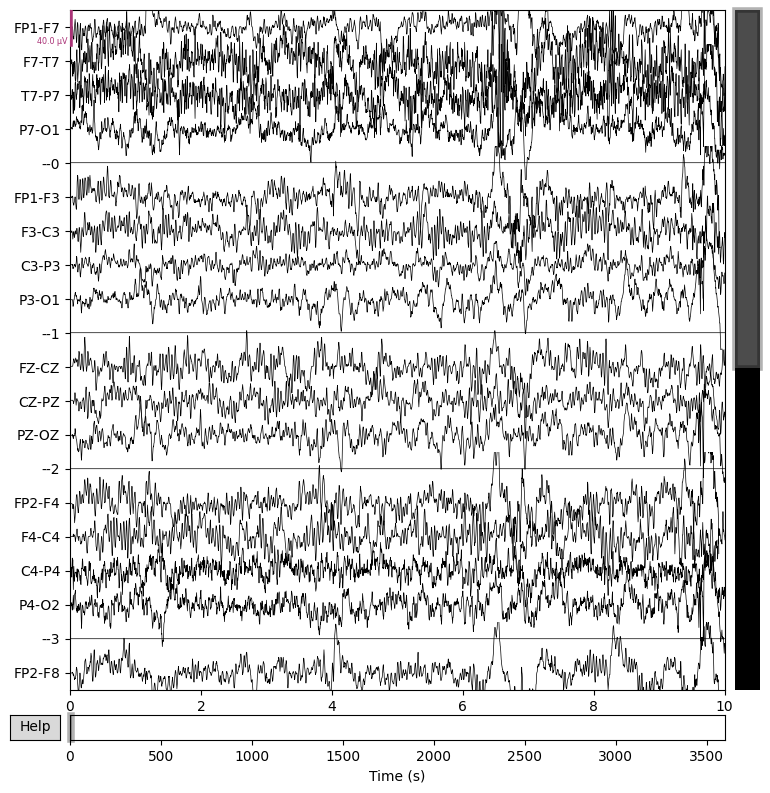

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.53 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.53
- Lower transition bandwidth: 0.53 Hz (-6 dB cutoff frequency: 0.27 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1595 samples (6.230 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,-101,-110,-173,-232,-261,-273,-285,-296,-291,-275,...,-223,-219,-154,-75,-50,-115,-240,-349,-375,-308
1,-342,-376,-323,-220,-118,-58,-67,-160,-326,-520,...,-26,-22,-3,28,75,138,199,229,203,133
2,529,578,657,697,626,425,137,-148,-360,-474,...,109,218,242,179,68,-28,-62,-29,31,65
3,34,72,125,189,246,273,261,223,181,144,...,-172,-121,-79,-18,69,164,244,295,313,293
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-388,-365,-334,-296,-253,-209,-171,-158,-181,-241,...,-301,-322,-316,-308,-325,-362,-375,-318,-189,-45
6,32,50,85,142,194,208,169,96,21,-38,...,-72,-21,-1,-12,-28,-23,3,25,15,-28
7,102,115,162,221,247,206,104,-20,-118,-172,...,-63,-19,30,84,125,135,108,58,10,-16
8,349,348,356,343,275,131,-75,-302,-503,-654,...,128,209,276,337,383,403,396,367,322,263
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
sig = chb_read_and_process(r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\chb15_28.edf', 
                           start=1000)

save_rows_to_csv(sig, dir_path=r'C:\Users\dibmir\OneDrive - Zucchetti S.P.A\Desktop\Università\DSIM\src\eeg_test')
sig